In [1]:
import matplotlib.pyplot as plt  
import pandas as pd  
import numpy as np 
import seaborn as sns
import os, sys
from hsbmpy import get_file, define_labels, get_cluster_given_l, get_max_available_L
from geneontology import topic_analysis
import tensorflow as tf
from sklearn.metrics import homogeneity_completeness_v_measure
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from sklearn.decomposition import LatentDirichletAllocation
from lda import lda
sys.path.append('/home/jovyan/phd/')
sys.path.append('/home/jovyan/phd/hsbm-occam/')

In [2]:
level = 2
directory=r"/home/jovyan/work/phd/topics/datasets/gtexhk"
#L=get_max_available_L(directory)
os.chdir(directory)
os.listdir()

['.DS_Store',
 'clustersizes.txt',
 'corpus.txt',
 'files.dat',
 'files_shuffles.dat',
 'graph.xml.gz',
 'hierarchical-log',
 'hierarchical_dendogram.pdf',
 'lda',
 'mainTable.csv',
 'metric_scores_all.pdf',
 'metric_scores_all_normhsbm.pdf',
 'modulemembership.pdf',
 'moduleTrait.pdf',
 'netdendograms.pdf',
 'nethier.pdf',
 'samplehier.svg',
 'samplehiercut.pdf',
 'scaletopology.pdf',
 'time_seed.dat',
 'tm',
 'topicsizes.txt',
 'topsbm',
 'wgcna',
 'wgcna-block.1.RData']

In [3]:
df = pd.read_csv("mainTable.csv", index_col=[0], header=[0]).dropna()
totalobjcets = len(df.columns)
print(df.info())
print("Maximum expression value: %.1e"%df.max().max())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, ENSG00000114480 to ENSG00000086827
Columns: 1000 entries, GTEX-111CU-1426-SM-5GZYP to GTEX-ZZPU-0926-SM-5GZYT
dtypes: float64(1000)
memory usage: 22.9+ MB
None
Maximum expression value: 6.3e+04


,GTEX-111CU-1426-SM-5GZYP,GTEX-111FC-0226-SM-5N9B8,GTEX-111YS-0006-SM-5NQBE,GTEX-111YS-0326-SM-5GZZ3,GTEX-111YS-2426-SM-5GZZQ,GTEX-1122O-0005-SM-5O99J,GTEX-1122O-0426-SM-5H12G,GTEX-1122O-0626-SM-5N9B9,GTEX-1122O-1026-SM-9WYSF,GTEX-1122O-1526-SM-5N9CL,...,GTEX-ZYT6-1726-SM-5E44P,GTEX-ZYT6-2826-SM-5GICX,GTEX-ZYVF-1126-SM-5E458,GTEX-ZYW4-2226-SM-5GZYG,GTEX-ZYY3-0526-SM-5E45G,GTEX-ZZ64-0826-SM-5E449,GTEX-ZZPT-3026-SM-5GZXH,GTEX-ZZPU-0226-SM-5N9BV,GTEX-ZZPU-0826-SM-5GZX5,GTEX-ZZPU-0926-SM-5GZYT
ENSG00000114480,14.050,35.01,9.654,34.80,81.870,17.030,96.92,37.95,16.430,11.340,...,3.075,13.45,30.00,129.100,131.900,10.89,4.682,40.28,16.610,32.150
ENSG00000181915,7.829,11.03,3.107,11.41,8.587,3.321,16.10,12.79,7.125,6.084,...,1.478,20.46,14.35,8.811,8.155,15.95,14.930,13.54,9.322,9.029


In [4]:
df_files = pd.read_csv("files.dat", index_col=[0])
df_files.head(3)

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-111CU-1426-SM-5GZYP,1.0,B1,"6 pieces, predominantly mucosa and submucosa w...",7.8,Colon,Colon - Transverse,0001157,100.0,609.0,BP-43693,...,17849000.0,13405900.0,0.002758,18057000.0,50.2897,0.007861,0.995609,NaN,0.0,49.8847
GTEX-111FC-0226-SM-5N9B8,2.0,B1,"2 pieces, larger piece is 30% fibrovascular ti...",7.3,Adipose Tissue,Adipose - Subcutaneous,0002190,1040.0,869.0,BP-43989,...,20831300.0,17554200.0,0.003104,20911100.0,50.0955,0.003755,0.993892,NaN,0.0,50.1164
GTEX-111YS-0006-SM-5NQBE,NaN,B1,NaN,8.2,Blood,Whole Blood,0013756,-121.0,NaN,BP-38780,...,18081500.0,17940700.0,0.004281,17976300.0,49.8542,0.002786,0.988644,NaN,0.0,50.3820


In [5]:
true_out = []
label = "cancer.type"
label = "Type"
label = "SMTS"
if label not in df_files.columns:
    raise AttributeError(f"{label} not Avaliable")
for sample in df.columns.values:
    try:
        true_out.append(get_file(sample, df_files)[label])
    except:
        print(*sys.exc_info())
        true_out.append('unknown')

In [6]:
scores = {}

In [7]:
try:
    with open("clustersizes.txt",'r') as f:
        xl = np.sort(np.array(f.read().split(sep='\n'))[:-1].astype(int))
except:
        xl=np.linspace(2,50,3, dtype=int)
xl

array([ 6, 32])

In [42]:
xl=xl[:-1]
xl

array([  2,   4,  12,  33, 208])

## hierarchical

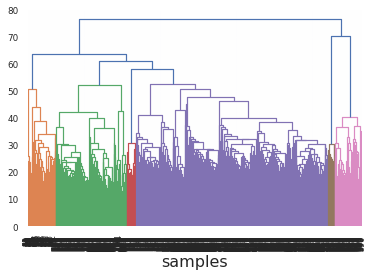

In [8]:
fig=plt.figure()
dend = shc.dendrogram(shc.linkage(np.log2(df.T.values+1), method='average'), leaf_rotation=90., leaf_font_size=8.,)
plt.xlabel("samples", fontsize=16)
plt.show()
fig.savefig("hierarchical_dendogram.pdf")

In [8]:
#hierarchical
scores['hierarchical']={
    'h':[],
    'c':[],
    'V':[]
}
def pearson_affinity(M, parallel=True):
    return 1 - np.array([[pearsonr(a,b)[0] for a in M] for b in M])

print("hierarchical-log")
os.system('mkdir -p hierarchical-log')
hierarchical_model = AgglomerativeClustering(n_clusters=1, affinity='euclidean', linkage='complete')  
for l,x in enumerate(xl):
    print("testing with %d clusters"%x)
    hierarchical_model.n_clusters=x
    data = np.log2(1.+df.T.values)
    #data = df.T.values
    out = hierarchical_model.fit_predict(data)
        
    #save clusters
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(len(df.columns)))
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df.columns[np.argwhere(out==c)].T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(len(df.columns)-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierarchical-log/hierarchical-log_level_%d_clusters.csv"%(l), index=False, header=True)

hierarchical-log
testing with 6 clusters
saving clusters


<ipython-input-8-8bba6241690e>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]


testing with 32 clusters
saving clusters


<ipython-input-8-8bba6241690e>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]


## LDA

In [ ]:
with open("topicsizes.txt",'r') as f:
    tl = np.array(f.read().split(sep='\n'))[:-1].astype(int)

In [11]:
xl = xl[:-1]
print(xl)

[11 78]


In [12]:
model=lda(n_jobs=4, verbose=2,  max_iter=5)
model.full_analysis(directory, xl, tl=None, logarithmise=False, label=label)

model created
<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, ENSG00000268903 to ENSG00000008735
Columns: 17382 entries, GTEX-1117F-0226-SM-5GZZ7 to GTEX-ZZPU-2726-SM-5NQ8O
dtypes: int64(17382)
memory usage: 57.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 22951 entries, GTEX-1117F-0003-SM-58Q7G to K-562-SM-E9EZZ
Data columns (total 62 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SMATSSCR   15739 non-null  float64
 1   SMCENTER   22724 non-null  object 
 2   SMPTHNTS   15737 non-null  object 
 3   SMRIN      19998 non-null  float64
 4   SMTS       22951 non-null  object 
 5   SMTSD      22951 non-null  object 
 6   SMUBRID    22951 non-null  object 
 7   SMTSISCH   22650 non-null  float64
 8   SMTSPAX    15715 non-null  float64
 9   SMNABTCH   22575 non-null  object 
 10  SMNABTCHT  22575 non-null  object 
 11  SMNABTCHD  22575 non-null  object 
 12  SMGEBTCH   22228 non-null  object 
 13  SMGEBTCHD  22209 non-null  

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.1s remaining:    7.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s finished


saving word-distr
saving topic-distr
saving clusters


/home/jovyan/work/phd/lda.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]


saving metrics


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s finished


testing with 78 clusters and 78 topics
lda()


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.5s remaining:    6.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.9s remaining:    7.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.6s finished


saving word-distr
saving topic-distr
saving clusters


/home/jovyan/work/phd/lda.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]


saving metrics


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.9s remaining:    5.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.3s finished


In [ ]:
topic_analysis(directory,1, 'lda')

## LDA Mallet

In [ ]:
from gensim.models.wrappers import LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import get_tmpfile
from gensim.corpora import MmCorpus

In [ ]:
corpus=list(map(list,map(lambda x: list(zip(range(len(df.index)), df[x])),df.columns)))
corpus

In [ ]:
dictionary=Dictionary([df.index])
[a for a in dictionary.items()]

In [ ]:
out_file=get_tmpfile("/home/fvalle/phd/datasets/tcga/oversampling_10tissue/corpus.mm")
MmCorpus.serialize(out_file, corpus, dictionary)

In [ ]:
model = LdaMallet("/home/fvalle/phd/Mallet/bin/mallet", workers=5, corpus=corpus, num_topics=15, id2word=dictionary)

In [ ]:
df_topics=pd.DataFrame(data=model.get_topics().T, index=[a[1] for a in dictionary.items()], columns=["Topic %d"%(t+1) for t in range(5)])
df_topics

In [ ]:
df_topic_distr=pd.read_csv(model.fdoctopics(), sep='\t', header=None, index_col=0).drop(1,1)
df_topic_distr.columns=["Topic %d"%(t+1) for t in range(5)]
df_topic_distr.index=df.columns
df_topic_distr

In [ ]:
df_topic_distr.apply(lambda x: x.idxmax().split(" ")[1], axis=1)

## hierachical on Altmann's output

In [ ]:
hiermodel = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')

In [ ]:
with open('clustersizes.txt') as f:
    xl=np.array(f.read().split('\n')[:-1]).astype(int)

In [ ]:
os.system("mkdir -p hierhsbm")

In [ ]:
true_out = []
for sample in pd.read_csv("%s/%s_level_%d_topic-dist.csv"%('topsbm','topsbm',0), index_col=1).drop('i_doc', axis=1).index.values:
    try:
        true_out.append(get_file(sample, df_files)['primary_site'])
    except:
        print(sys.exc_info()[0])
        true_out.append('')

In [ ]:
scores['hierhsbm']={
    'h':[],
    'c':[],
    'V':[]
}
for l,n_clusters in enumerate(xl):
    print("Fitting level %d with %d clusters"%(l, n_clusters))
    df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%('topsbm','topsbm',l), index_col=1).drop('i_doc', axis=1)
    df_clusters = pd.DataFrame(columns=["Cluster %d"%c for c in np.arange(n_clusters)+1])
    hiermodel.n_clusters=n_clusters
    out = hiermodel.fit_predict(df_topics.values)  
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df_topics.index[np.argwhere(out==c)].values.T[0]
        df_clusters["Cluster %d"%(c+1)]=np.concatenate((c_objects,[np.nan for _ in np.arange(len(df_topics.index)-len(c_objects))]))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierhsbm/hierhsbm_level_%d_clusters.csv"%(l), index=False, header=True)
    #metrics
    print("saving metrics")
    score = (homogeneity_completeness_v_measure(true_out, out))
    scores['hierhsbm']['h'].append(score[0])
    scores['hierhsbm']['c'].append(score[1])
    scores['hierhsbm']['V'].append(score[2])
    
pd.DataFrame(data=scores['hierhsbm']).to_csv("%s/hierhsbm.scores"%directory, header=True, index=False)

# Topic mapping

In [16]:
df=pd.read_csv("mainTable.csv", index_col=0)
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, ENSG00000229344.1 to ENSG00000210196.2
Columns: 1000 entries, GTEX-PLZ4-1226-SM-2I5FE to GTEX-1LVAN-1026-SM-CNNQZ
dtypes: int64(1000)
memory usage: 22.9+ MB


,GTEX-PLZ4-1226-SM-2I5FE,GTEX-1EMGI-2726-SM-7P8S4,GTEX-1C2JI-0008-SM-EXOHZ,GTEX-1S5ZU-2526-SM-E6CIF,GTEX-11EMC-3226-SM-5EGKW,GTEX-11ZUS-2926-SM-5FQSL,GTEX-18465-0226-SM-7LG5M,GTEX-1I1GU-0926-SM-ACKVS,GTEX-1JMLX-2326-SM-CXZJP,GTEX-1B996-1726-SM-7IGMW,...,GTEX-14JG1-0826-SM-5ZZWR,GTEX-14PK6-0826-SM-5ZZVO,GTEX-1ICLY-0526-SM-A9G36,GTEX-ZDTS-0226-SM-5HL7Q,GTEX-1HCU6-1026-SM-A9G25,GTEX-1IKOH-0011-R2a-SM-CMKHO,GTEX-14JG6-1226-SM-664O6,GTEX-Z93S-0526-SM-EVYB4,GTEX-11DXX-0626-SM-5Q5AG,GTEX-1LVAN-1026-SM-CNNQZ
ENSG00000229344.1,41,115,11,4,40,35,27,11,3,8,...,9,1104,27,11,26,21,12,1,15,10
ENSG00000198744.5,50,215,4,6,176,69,41,22,5,10,...,12,253,33,13,4905,93,9,5,14,10


In [13]:
with open("corpus.txt",'w') as file:
    for sample in df.columns:
        for g in np.array(df[sample].sort_values(ascending=False).index[:1000],dtype=str):
            file.write(g[:15])
            file.write(" ")
        file.write("\n")
import gc
gc.collect()

651

Instructions on how to install it are available from its authors
[https://amaral.northwestern.edu/resources/software/topic-mapping](https://amaral.northwestern.edu/resources/software/topic-mapping)

```bash
export PATH=$PATH:/home/jovyan/work/topicmapping/bin
topicmap -f corpus.txt -r 10 -t 10 -seed 42 -o tm
```

In [ ]:
os.system("export PATH=$PATH:/home/jovyan/work/topicmapping/bin")
os.system("topicmap -f corpus.txt -r 10 -t 10 -seed 42 -o tm")

In [16]:
df_words = pd.read_csv("tm/word_wn_count.txt", sep=' ', header=None)
df_words.columns=['word', 'word-id', 'occurrence']
df_words.sort_values('word-id')

,word,word-id,occurrence
1918,ENSG00000107317,0,999
1919,ENSG00000154146,1,999
1939,ENSG00000198668,2,1000
1940,ENSG00000020129,3,1000
1762,ENSG00000129244,4,953
...,...,...,...
693,ENSG00000250884,2377,22
598,ENSG00000264580,2378,14
275,ENSG00000225298,2379,2
276,ENSG00000229163,2380,2


In [17]:
df_topic_distr = pd.read_csv("tm/lda_gammas_final.txt", sep=' ', header=None)
df_topic_distr.columns=['Topic %d'%(t+1) for t in df_topic_distr.columns]
df_topic_distr.index.name='i_doc'
df_topic_distr.insert(0,'doc',df.columns)
df_topic_distr=df_topic_distr.dropna(how='all',axis=1)

In [18]:
clusters = df_topic_distr.drop('doc',1).values.argmax(1)
df_clusters=pd.DataFrame()
for cluster in range(np.max(clusters)+1):
    elems=df.columns[clusters==cluster].values
    df_clusters.insert(0,'Cluster %d'%(cluster+1),np.concatenate([elems, ['' for _ in range(len(df.columns)- len(elems))]]))

In [19]:
df_clusters.sort_index(axis=1).to_csv("tm/tm_level_0_clusters.csv", index=False, header=True)
df_topic_distr.to_csv("tm/tm_level_0_topic-dist.csv", index=True, header=True)

In [20]:
df_word_distr = pd.DataFrame().fillna(0)
with open("tm/lda_betas_sparse_final.txt","r") as f:
    for line in f.read().split("\n"):
        row = line.split(" ")
        if len(row) < 2:
            continue
        topic = int(row[0])+1
        line=np.array(row[1:-1], dtype=float).reshape(int((len(row)-1)/2),2)
        for el in line:
            df_word_distr.at[df_words[df_words['word-id']==int(el[0])].word.values[0], f"Topic {topic}"] = el[1]
#df_word_distr.index=df_words['word']
df_word_distr.fillna(0)
df_word_distr.to_csv("tm/tm_level_0_word-dist.csv", index=True, header=True)

In [21]:
df_topics = pd.DataFrame()
max_L = df_word_distr.shape[0]
for topic in df_word_distr.columns[::-1]:
    t_series = df_word_distr[topic]
    t_series = t_series[t_series>t_series.quantile(0.99)]
    df_topics.insert(0,topic,np.concatenate((t_series.index.values,np.repeat(np.nan, df_word_distr.shape[0]-len(t_series)))))
df_topics.dropna(how="all", axis=0).to_csv("tm/tm_level_0_topics.csv", index=False, header=True)

# WGCNA

Use [WGCNA.ipynb](WGCNA.ipynb) to run analyses and come back here to adapt data to next analyses

In [14]:
from hsbmpy import get_max_available_L
for l in range(get_max_available_L(directory, "wgcna")+1):
    df_wgcna = pd.read_csv("wgcna/wgcna_level_%d_labels.csv"%l, index_col=0)
    totalobjcets = len(df_wgcna.index)
    out = df_wgcna['x'].values
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(totalobjcets))
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df_wgcna.index[np.argwhere(out==(c+1))].T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(totalobjcets-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("wgcna/wgcna_level_%d_clusters.csv"%l, index=False, header=True)
df_wgcna_td = pd.read_csv("wgcna/wgcna_level_0_topic-dist.csv")
df_wgcna_td.columns.values[0]='doc'
df_wgcna_td.index.name='i_doc'
df_wgcna_td.to_csv("wgcna/wgcna_level_0_topic-dist.csv", index=True)

saving clusters


<ipython-input-14-a4f532b20cd5>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df_wgcna.index[np.argwhere(out==(c+1))].T[0]


saving clusters


<ipython-input-14-a4f532b20cd5>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df_wgcna.index[np.argwhere(out==(c+1))].T[0]


saving clusters


<ipython-input-14-a4f532b20cd5>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df_wgcna.index[np.argwhere(out==(c+1))].T[0]


In [15]:
df_word_distr = pd.read_csv("wgcna/wgcna_level_0_word-dist.csv", index_col=0)
df_topics = pd.DataFrame()
max_L = df_word_distr.shape[0]
for topic in df_word_distr.columns[::-1]:
    t_series = df_word_distr[topic]
    t_series = t_series[t_series>0.5]
    df_topics.insert(0,topic.replace("MM","ME"),np.concatenate((t_series.index.values,np.repeat(np.nan, df_word_distr.shape[0]-len(t_series)))))
df_topics.dropna(how="all", axis=0).to_csv("wgcna/wgcna_level_0_topics.csv", index=False, header=True)

## hSBM

In [ ]:
for l in range(3):
    pd.read_csv("topsbm/topsbm_level_%d_topics.csv"%l).applymap(lambda x: str(x)[:15]).to_csv("topsbm/topsbm_level_%d_topics.csv"%l, index=False)